In [358]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [33]:
f1_prob = np.array([2/9, 3/9, 4/9])
f2_prob = np.array([4/29, 9/29, 16/29])
f3_prob = np.array([8/58, 18/58, 32/58])
f4_prob = np.array([24/89, 29/89, 36/89])

Text(0.5, 1.0, 'f4')

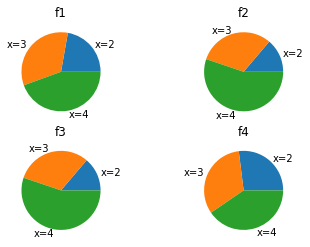

In [34]:
fig, axs = plt.subplots(2,2)
axs[0,0].pie(f1_prob, labels=['x=2','x=3','x=4'])
axs[0,0].set_title('f1')
axs[0,1].pie(f2_prob, labels=['x=2','x=3','x=4'])
axs[0,1].set_title('f2')
axs[1,0].pie(f3_prob, labels=['x=2','x=3','x=4'])
axs[1,0].set_title('f3')
axs[1,1].pie(f4_prob, labels=['x=2','x=3','x=4'])
axs[1,1].set_title('f4')


When you scale the fitness function up the selection pressure becomes larger because the probability values are more dispersed. The scaling up from f1 to f2 or f3 results in higher pressure because now there is a clear advantage for the higher x values. 

In [83]:
class SimpleGA: 
    def __init__(self, mu, bit_length, population_size, num_generations, num_runs, selection_type='normal'):
        self.mu = mu
        self.bit_length = bit_length
        self.population_size = population_size
        self.num_generations = num_generations
        self.num_runs = num_runs
        self.selection_type = selection_type
        self.population = []
        self.new_population = []
        self.max_fitness = [[] for _ in range(self.num_runs)]
        self.average_fitness = []

    def initial_pop(self):
        self.population = np.random.randint(0, 2, (self.population_size, self.bit_length))

    def fitness_function(self, byte):
        return sum(byte)/self.bit_length

    def mutation(self):
        self.new_population = np.copy(self.population)
        for r, byte in enumerate(self.new_population):
            for c, bit in enumerate(byte):
                if np.random.uniform(0,1) < self.mu:
                    if bit == 0:
                        self.new_population[r][c] = 1
                    else:
                        self.new_population[r][c] = 0

    def survivor_selection(self):
        for count, byte in enumerate(self.population):
            if self.fitness_function(self.new_population[count]) > self.fitness_function(byte):
                self.population[count] = self.new_population[count]

    def simple_survivor_selection(self):
        self.population = np.copy(self.new_population)

    def data_storage(self, run):
        fitness = [self.fitness_function(x) for x in self.population]
        # self.average_fitness.append(np.mean(fitness))
        self.max_fitness[run].append(max(fitness))

    def plot_fitness(self):
        plt.title('Simple (1 + 1)-GA')
        for run in range(self.num_runs):
            plt.plot(self.max_fitness[run], label=f'max fitness of run: {run+1}')
            # plt.plot(self.average_fitness, label=f'average fitness of run: {run+1}')
        plt.xlabel('generations')
        plt.ylabel('fitness value')
        # plt.legend()
        plt.show()


    def evolution(self):
        for run in range(self.num_runs):
            self.initial_pop()
            for _ in range(self.num_generations):
                self.data_storage(run)
                self.mutation()
                if self.selection_type == 'normal':
                    self.survivor_selection()
                else:
                    self.simple_survivor_selection()

        self.plot_fitness()

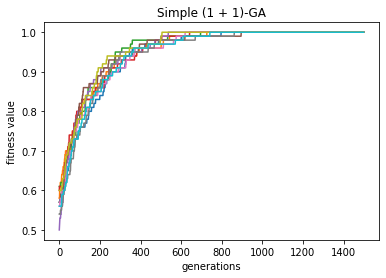

In [84]:
GA = SimpleGA(1/100, 100, 10, 1500, 10)
GA.evolution()

The algorithm find the optimum every time

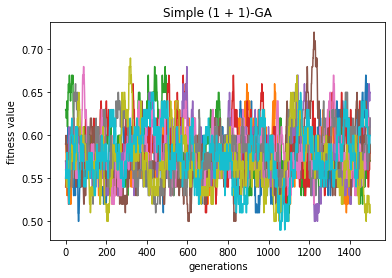

In [85]:
GA2 = SimpleGA(1/100, 100, 10, 1500, 10, 'simple')
GA2.evolution()

The second algorithm where the whole population is replaced by the mutated one is not improving because there is no selection taking place of the best individuals.

In [359]:
#import data from text file
filename = 'file-tsp.txt'
data = np.loadtxt(filename)

#create a dictionary of coordinates
def create_dictionary(data_input):
    numbers = [n+1 for n in range(len(data_input))]
    places = dict.fromkeys(numbers)
    for c, n in enumerate(numbers):
        places[n] = data_input[c]
    return places, numbers

places, number_list = create_dictionary(data)

In [172]:
# import data
filename = 'gr202.tsp'
data2 = open(filename, 'r')
data2 = data2.read().split('\n')[7:-2]
data2 = [x.split(' ')[2:] for x in data2]
data2 = [list(map(lambda x: float(x), y)) for y in data2]

In [174]:
places2, number_list2 = create_dictionary(data2)

In [569]:
class simpleEA:
    def __init__(self, population_dict, number_list, mu, K_value, population_size, num_generations, num_runs):
        self.mu = mu # mutation probability
        self.K_value = K_value # k-value for tournament selection
        self.num_generations = num_generations
        self.num_runs = num_runs
        self.population_dict = population_dict
        self.number_list = number_list
        self.population = []
        self.population_size = population_size
        self.new_population = []
        self.max_fitness = [[] for _ in range(self.num_runs)]
        self.best_coordinates = [[] for _ in range(self.num_runs)]
        # self.cutting_points = [int(1/4*len(self.number_list)), int(3/4*len(self.number_list))]
        self.cutting_points = []
        self.fitness_values = []

    def get_coordinates(self, population):
        coordinate_list = []
        for n in population:
            coordinate_list.append(list(self.population_dict[n]))

        return coordinate_list

    def delta_x(self, coord1, coord2):
        return self.population_dict[coord1][0] - self.population_dict[coord2][0]
    
    def delta_y(self, coord1, coord2):
        return self.population_dict[coord1][1] - self.population_dict[coord2][1]

    # initialize population of numbers where coordinates are stored in dictionary
    def initial_population(self):
        self.population = []
        new = np.copy(self.number_list)
        for _ in range(self.population_size):
            np.random.shuffle(new)
            new_list = np.copy(new)
            self.population.append(list(new_list))

    # calculate fitness by distance pythagoras
    def fitness_function(self, chromosome):
        total_distance = 0
        for c, n in enumerate(chromosome):
            if c != (len(chromosome) - 1):
                a = self.delta_x(n, chromosome[c+1])
                b = self.delta_y(n, chromosome[c+1])
            else:
                a = self.delta_x(n, chromosome[0])
                b = self.delta_y(n, chromosome[0])
            total_distance += np.sqrt((a)**2 + (b)**2)

        return total_distance
    
    def remove_duplicates(self, parent, duplicates):
        leftovers = list(np.copy(parent))
        for place in parent:
            if place in duplicates:
                leftovers.remove(place)
        return leftovers
    
    # Crossover as seen in the lecture    
    def crossover(self):
        #create random parent pairs
        random_pairs = [x for x in range(0,self.population_size)]
        np.random.shuffle(random_pairs)
        random_pairs = np.array(random_pairs)
        random_pairs.shape = (int(self.population_size/2),2) #change shape to pairs
        self.new_population = []

        for pair in random_pairs:
            self.cutting_points = np.sort([np.random.randint(0,len(self.number_list)), np.random.randint(0,len(self.number_list))])
            parent1, parent2 = self.population[pair[0]], self.population[pair[1]]
            child1 = np.copy(parent1)
            child2 = np.copy(parent2)
            parent1_numbers = parent1[self.cutting_points[0]:self.cutting_points[1]]
            parent2_numbers = parent2[self.cutting_points[0]:self.cutting_points[1]]
            parent1_left = self.remove_duplicates(parent1, parent2_numbers)
            parent2_left = self.remove_duplicates(parent2, parent1_numbers)
            counter = 0
            for c, n in enumerate(parent1_left):
                if (c + self.cutting_points[1]) < len(child1):
                    child1[c + self.cutting_points[1]] = parent2_left[c]
                    child2[c + self.cutting_points[1]] = parent1_left[c]
                else:
                    child1[counter] = parent2_left[c]
                    child2[counter] = parent1_left[c]       
                    counter += 1

            self.new_population.append(child1); self.new_population.append(child2) 

    # Mutation is a simple swap of two coordinates
    def mutation(self):
        for count, chromosome in enumerate(self.new_population):
            mutated_chromosome = np.copy(chromosome)
            if np.random.uniform(0,1) < self.mu:
                point1, point2  = np.random.randint(0, len(self.number_list),(2))     
                mutated_chromosome[point1], mutated_chromosome[point2] = chromosome[point2], chromosome[point1]
            
            self.new_population[count] = mutated_chromosome

    # Tournament selection with K participants 
    def tournament_selection(self):
        self.population = list(self.population)
        self.population += list(self.new_population)
        self.new_population = []
        self.fitness_values = [self.fitness_function(x) for x in self.population]
        participants = np.random.choice(range(len(self.population)), (self.population_size,self.K_value))
        new_fitness = []
        for participant in participants:
            # participants = np.random.choice(range(len(self.population)), self.K_value, replace=False)
            fitness_participants = [self.fitness_values[x] for x in participant]
            self.new_population.append(self.population[participant[np.argmin(fitness_participants)]])
            new_fitness.append(self.fitness_values[participant[np.argmin(fitness_participants)]])
        self.population = np.copy(self.new_population)
        self.fitness_values = np.copy(new_fitness)

    # simple selection algorithm where best is chosen from parent or child
    def simple_selection(self):
        self.population = list(self.population)
        self.population += list(self.new_population)
        self.new_population = []
        self.fitness_values = [self.fitness_function(x) for x in self.population]
        new_fitness = []
        for count in range(self.population_size):
            if self.fitness_values[count] < self.fitness_values[count + self.population_size]:
                self.new_population.append(self.population[count])
                new_fitness.append(self.fitness_values[count])
            else:
                self.new_population.append(self.population[count + self.population_size]) 
                new_fitness.append(self.fitness_values[count + self.population_size])

        self.population = np.copy(self.new_population)
        self.fitness_values = np.copy(new_fitness)
           



    # Store data for plots
    def data_storage(self, run):
        best_fitness = np.argmin(self.fitness_values)
        self.max_fitness[run].append(self.fitness_values[best_fitness])
        self.best_coordinates[run].append(self.population[best_fitness])
    
    # plot max fitness values in a graph
    def plot_fitness(self):
        plt.title('Simple EA for TSP')
        for run in range(self.num_runs):
            plt.plot(self.max_fitness[run], label=f'max fitness of run: {run}')
        plt.xlabel('generations')
        plt.ylabel('fitness value')
        plt.show()

    # plot map of shortest road found by algorithm
    def plot_road(self, run):
        plt.figure(figsize=(15,15))

        plt.title(f'best path of TSP of run: {run}')
        coordinates = self.get_coordinates(self.best_coordinates[run][-1])
        plt.scatter([x[0] for x in coordinates], [x[1] for x in coordinates])
        for i in range(len(coordinates)):
            if i < len(coordinates) - 1:
                start_node = coordinates[i]
                next_node = coordinates[i + 1]
            else:
                start_node = coordinates[-1]
                next_node = coordinates[0]

            plt.annotate("",
                xy=start_node, xycoords='data',
                xytext=next_node, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))

        plt.show()

        
    # Run evolution process
    def evolution(self):
        for run in range(self.num_runs):
            self.initial_population()
            for _ in range(self.num_generations):
                self.crossover()
                self.mutation()
                self.tournament_selection()
                # self.simple_selection()
                self.data_storage(run)
            # print(self.population)
            self.plot_road(run)
        self.plot_fitness()

    

In [572]:
class MemeticAlgorithm:
    def __init__(self, population_dict, number_list, mu, K_value, population_size, num_generations, num_runs):
        self.mu = mu # mutation probability
        self.K_value = K_value # how many participants in tournament selection
        self.num_generations = num_generations
        self.num_runs = num_runs
        self.population_dict = population_dict
        self.number_list = number_list
        self.population = []
        self.population_size = population_size
        self.new_population = []
        self.max_fitness = [[] for _ in range(self.num_runs)]
        self.best_coordinates = [[] for _ in range(self.num_runs)]
        self.cutting_points = []
        self.fitness_values = []

    # function to get coordinates out of dictionary
    def get_coordinates(self, population):
        coordinate_list = []
        for n in population:
            coordinate_list.append(list(self.population_dict[n]))

        return coordinate_list

    # distance on x-axis
    def delta_x(self, coord1, coord2):
        return self.population_dict[coord1][0] - self.population_dict[coord2][0]
    
    # distance on y-axis
    def delta_y(self, coord1, coord2):
        return self.population_dict[coord1][1] - self.population_dict[coord2][1]

    # create the initial population
    def initial_population(self):
        self.population = []
        new = np.copy(self.number_list)
        for _ in range(self.population_size):
            np.random.shuffle(new)
            new_list = np.copy(new)
            self.population.append(list(new_list))

    # calculate the fitness of the individual
    def fitness_function(self, chromosome):
        total_distance = 0
        for c, n in enumerate(chromosome):
            if c != (len(chromosome) - 1):
                a = self.delta_x(n, chromosome[c+1])
                b = self.delta_y(n, chromosome[c+1])
            else:
                a = self.delta_x(n, chromosome[0])
                b = self.delta_y(n, chromosome[0])
            total_distance += np.sqrt((a)**2 + (b)**2)

        return total_distance
    
    def remove_duplicates(self, parent, duplicates):
        leftovers = list(np.copy(parent))
        for place in parent:
            if place in duplicates:
                leftovers.remove(place)
        return leftovers
    
    # Crossover as seen in the lecture    
    def crossover(self):
        #create random parent pairs
        random_pairs = [x for x in range(0,self.population_size)]
        np.random.shuffle(random_pairs)
        random_pairs = np.array(random_pairs)
        random_pairs.shape = (int(self.population_size/2),2) #change shape to pairs
        self.new_population = []

        for pair in random_pairs:
            self.cutting_points = np.sort([np.random.randint(0,len(self.number_list)), np.random.randint(0,len(self.number_list))])
            parent1, parent2 = self.population[pair[0]], self.population[pair[1]] # select parents from randomly chosen pairs
            child1 = np.copy(parent1)
            child2 = np.copy(parent2)
            parent1_numbers = parent1[self.cutting_points[0]:self.cutting_points[1]]
            parent2_numbers = parent2[self.cutting_points[0]:self.cutting_points[1]]
            parent1_left = self.remove_duplicates(parent1, parent2_numbers)
            parent2_left = self.remove_duplicates(parent2, parent1_numbers)
            counter = 0
            # start after cutting point and when finished go to beginning of array, filling in the non-duplicate values of other parent
            for c, n in enumerate(parent1_left):
                if (c + self.cutting_points[1]) < len(child1):
                    child1[c + self.cutting_points[1]] = parent2_left[c]
                    child2[c + self.cutting_points[1]] = parent1_left[c]
                else:
                    child1[counter] = parent2_left[c]
                    child2[counter] = parent1_left[c]       
                    counter += 1

            self.new_population.append(child1); self.new_population.append(child2) 

    # Mutation is a simple swap of two coordinates
    def mutation(self):
        for count, chromosome in enumerate(self.new_population):
            mutated_chromosome = np.copy(chromosome)
            if np.random.uniform(0,1) < self.mu:
                point1, point2  = np.random.randint(0, len(self.number_list),(2))     
                mutated_chromosome[point1], mutated_chromosome[point2] = chromosome[point2], chromosome[point1]
            
            self.new_population[count] = mutated_chromosome

    # Tournament selection with K participants 
    def tournament_selection(self):
        self.population = list(self.population)
        self.population += list(self.new_population)
        self.new_population = []
        self.fitness_values = [self.fitness_function(x) for x in self.population]
        participants = np.random.choice(range(len(self.population)), (self.population_size,self.K_value))
        new_fitness = []
        for participant in participants:
            fitness_participants = [self.fitness_values[x] for x in participant]
            self.new_population.append(self.population[participant[np.argmin(fitness_participants)]])
            new_fitness.append(self.fitness_values[participant[np.argmin(fitness_participants)]])
        self.population = np.copy(self.new_population)
        self.fitness_values = np.copy(new_fitness)  

    # brute force local search 
    def local_search(self):
        for count, chromosome in enumerate(self.population):
            original = np.copy(chromosome)
            for n in range(self.population_size): 
                new_chromosome = np.copy(original)
                point1, point2  = np.random.randint(0, len(self.number_list),(2))     
                new_chromosome[point1], new_chromosome[point2] = original[point2], original[point1]
                if self.fitness_function(new_chromosome) >= self.fitness_function(original):
                    continue
                else:
                    original = np.copy(new_chromosome)
            self.population[count] = np.copy(original)

    #swap part of route
    def two_opt_swap(self, route, v1, v2):
        new_route = np.copy(route)
        new_route[v1+1:v2+1] = np.flip(route[v1+1:v2+1])
        return new_route

    #two_opt algorithm
    def two_opt(self):
        for index, chromosome in enumerate(self.new_population):
            x = np.random.randint(0, len(chromosome))
            # best_distance = self.fitness_function(chromosome)
            new_chromosome = np.copy(chromosome)
            for i in range(x,len(chromosome) - 2):
                for j in range(i+1, len(chromosome) - 1):
                    new_route = self.two_opt_swap(new_chromosome, i, j)
                    # new_distance = self.fitness_function(new_route)
                    d_a = (self.fitness_function(new_chromosome[i:i+2]), self.fitness_function(new_chromosome[j+1:j+3]))
                    d_b = (self.fitness_function(new_route[i:i+2]), self.fitness_function(new_route[j+1:j+3]))
                    # print(new_chromosome[i:i+2],self.fitness_function(new_chromosome[i:i+2]))
                    if sum(d_b) <= sum(d_a):
                        # print('swap', d_b - d_a)
                        new_chromosome = np.copy(new_route)
                        # best_distance = new_distance
                        continue
                    else:
                        self.new_population[index] = np.copy(new_chromosome)
                        break
                break
                



    # Store data for plots
    def data_storage(self, run):
        best_fitness = np.argmin(self.fitness_values)
        self.max_fitness[run].append(self.fitness_values[best_fitness])
        self.best_coordinates[run].append(self.population[best_fitness])
    
    # plot max fitness values in a graph
    def plot_fitness(self):
        plt.title('Memetic EA for TSP')
        for run in range(self.num_runs):
            plt.plot(self.max_fitness[run], label=f'max fitness of run: {run}')
        # plt.plot(self.average_fitness, label=f'average fitness of run: {run+1}')
        plt.xlabel('generations')
        plt.ylabel('fitness value')
        plt.show()

    # plot map of shortest road found by algorithm
    def plot_road(self, run):
        plt.figure(figsize=(15,15))

        plt.title(f'best path of TSP of run: {run}')
        coordinates = self.get_coordinates(self.best_coordinates[run][-1])
        plt.scatter([x[0] for x in coordinates], [x[1] for x in coordinates])
        for i in range(len(coordinates)):
            if i < len(coordinates) - 1:
                start_node = coordinates[i]
                next_node = coordinates[i + 1]
            else:
                start_node = coordinates[-1]
                next_node = coordinates[0]

            plt.annotate("",
                xy=start_node, xycoords='data',
                xytext=next_node, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
        plt.show()

        
    # Run evolution process
    def evolution(self):
        for run in range(self.num_runs):
            self.initial_population()
            for _ in range(self.num_generations):
                self.crossover()
                self.mutation()
                self.two_opt()
                self.tournament_selection()
                # self.local_search()
                self.data_storage(run)
            # print(len(self.population))
            self.plot_road(run)
        self.plot_fitness()
    

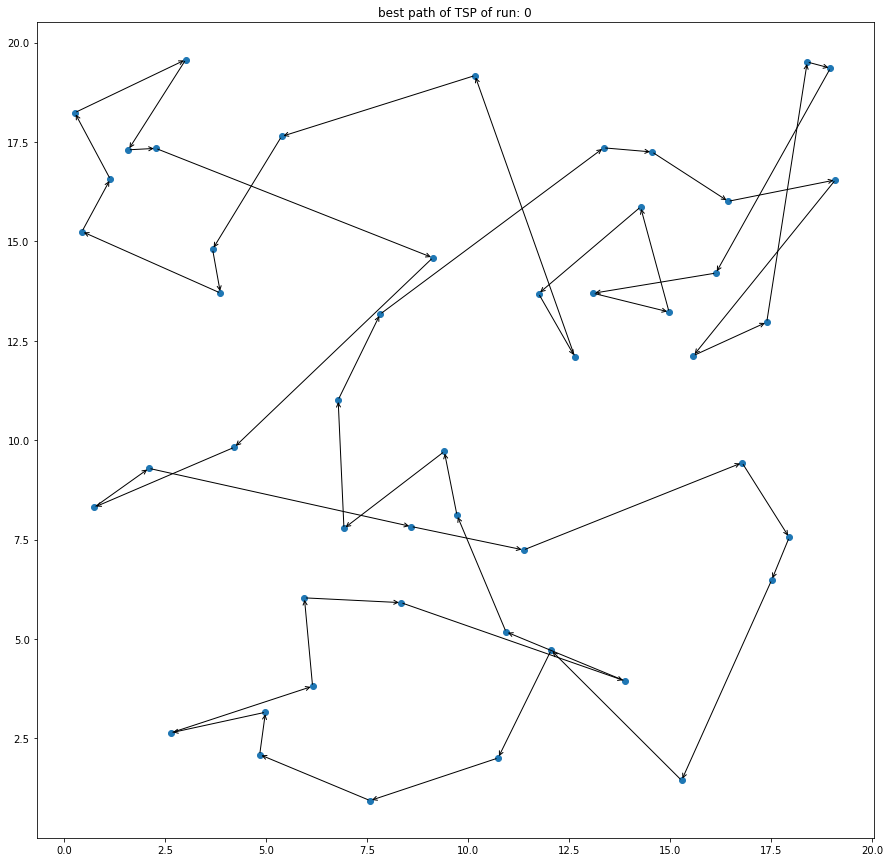

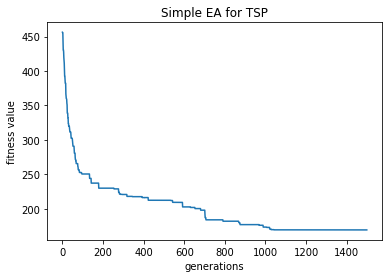

In [570]:
# run simple algorithm with first dataset
EA = simpleEA(places, number_list, 0.2, 5, 10 ,1500, 1)
EA.evolution()

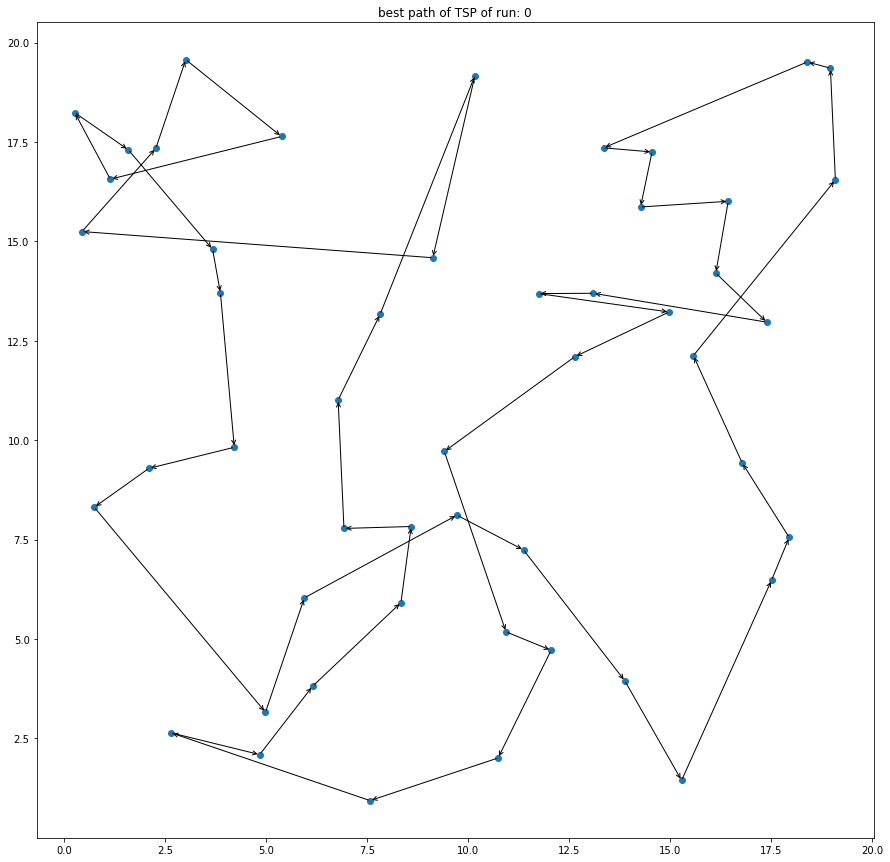

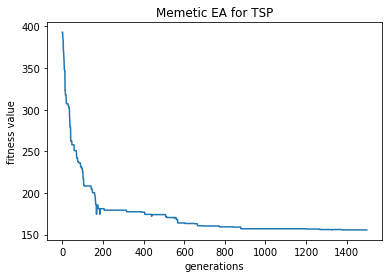

In [576]:
# run memetic algorithm with first dataset
MA = MemeticAlgorithm(places, number_list, 0.2, 4, 10 ,1500, 1) # (population dictionary, list of numbers of places, mutation probability, K-value, population size, num generations, num run)
MA.evolution()

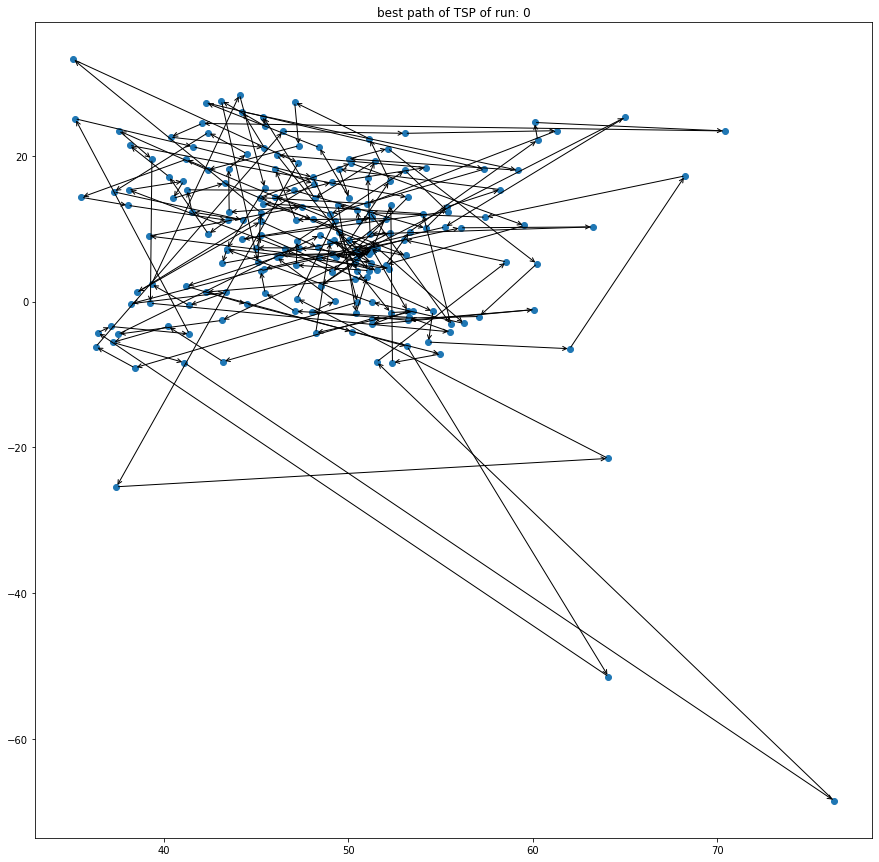

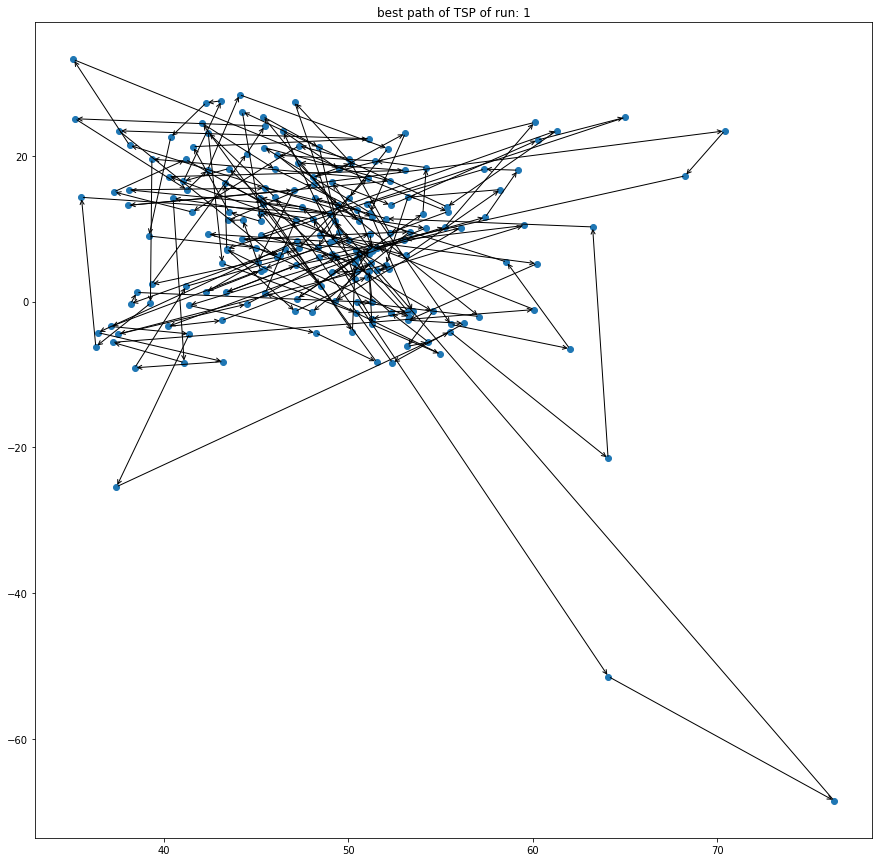

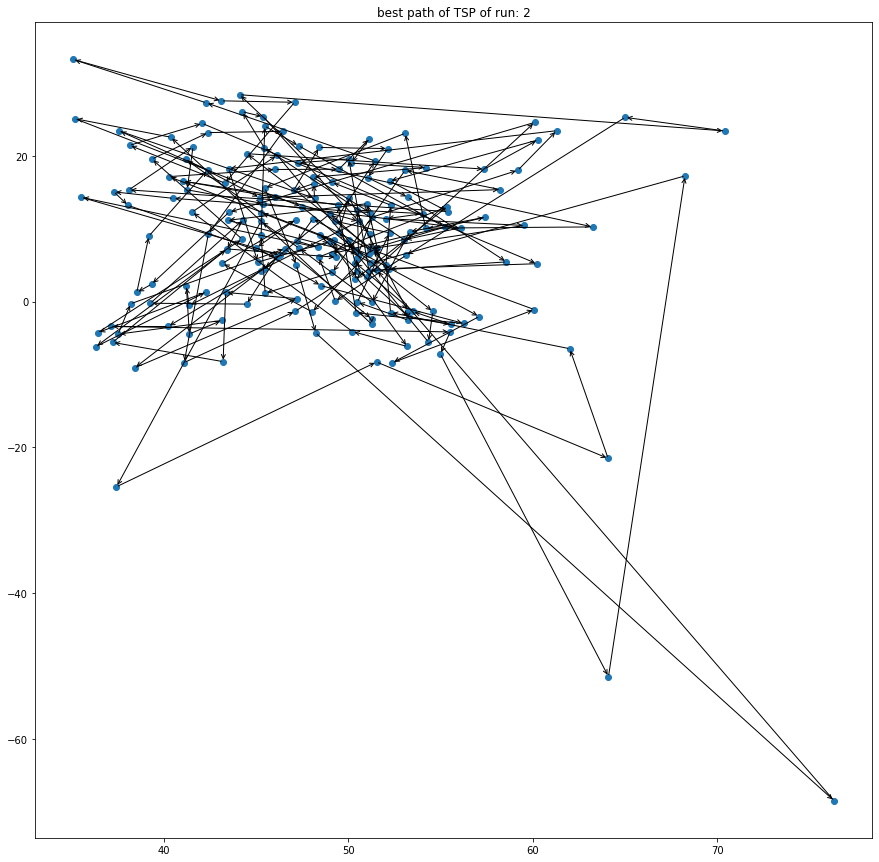

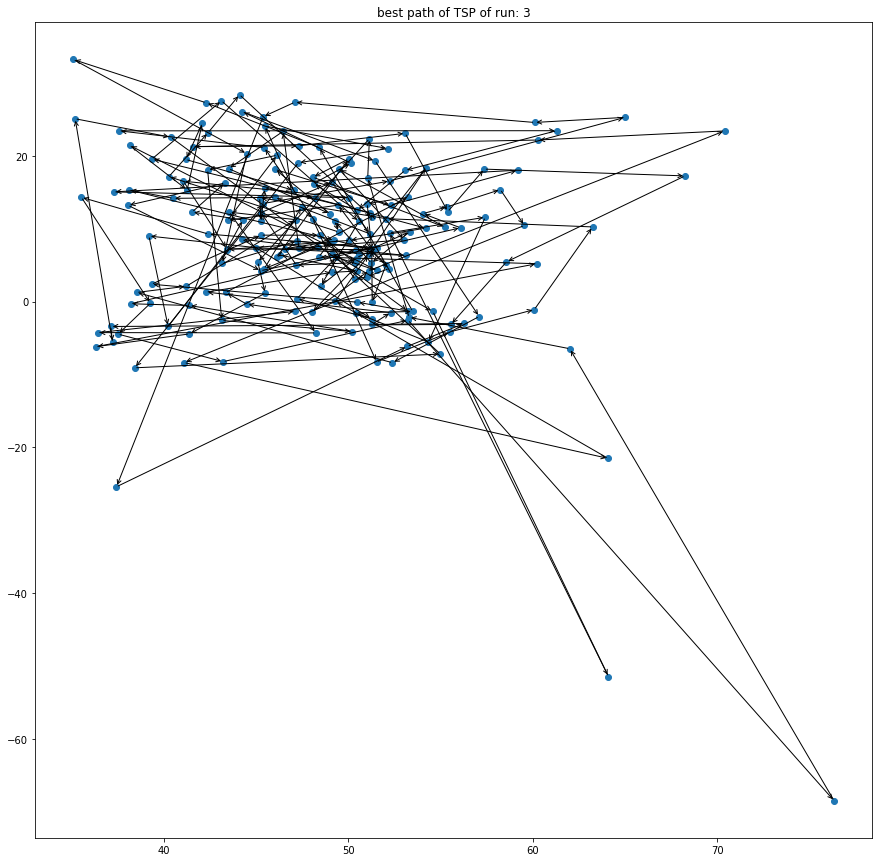

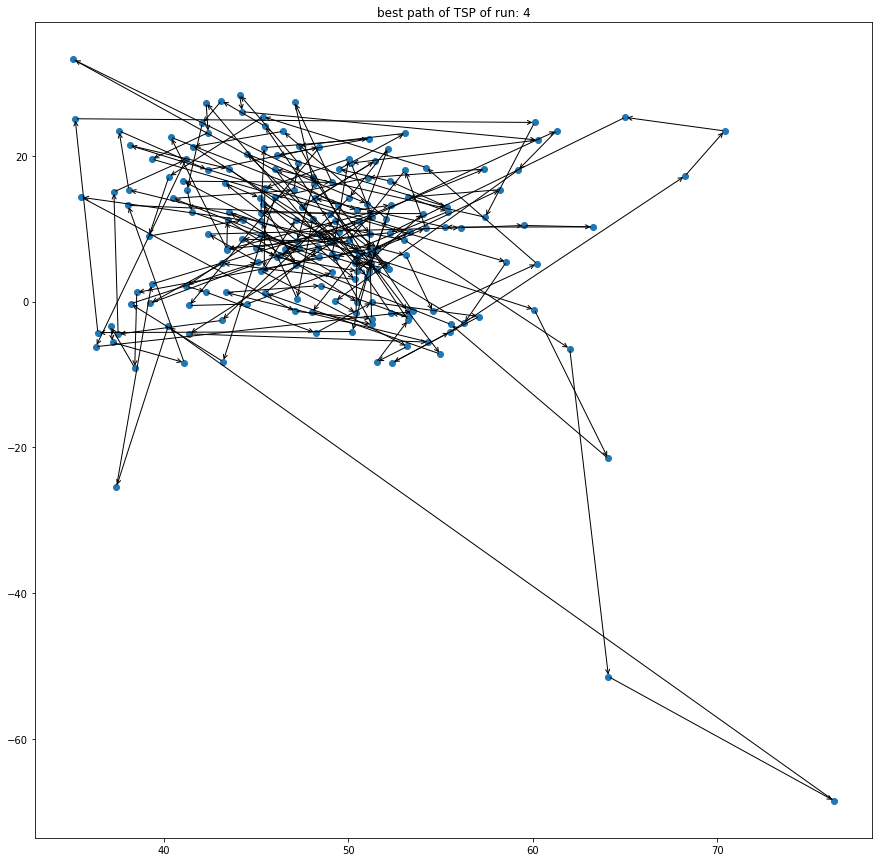

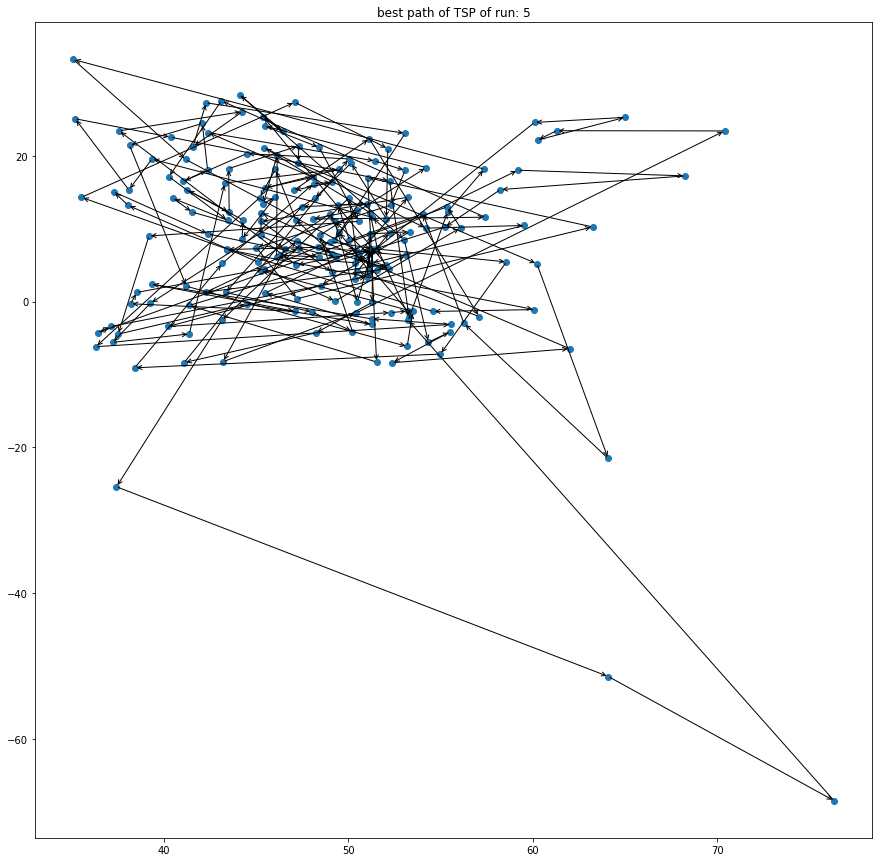

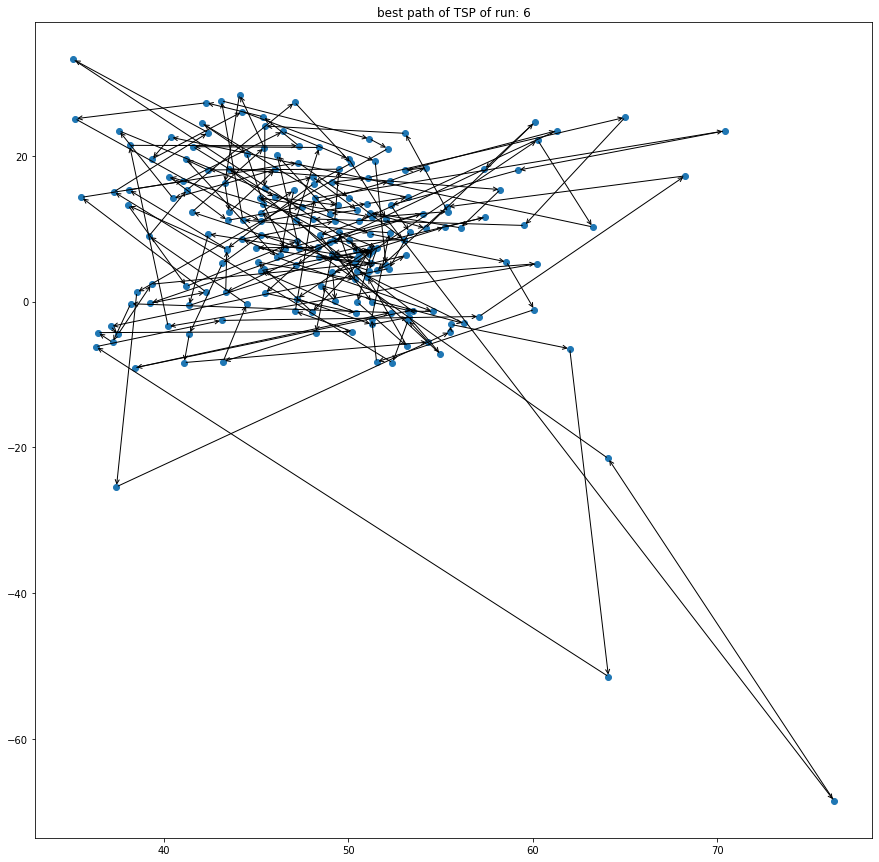

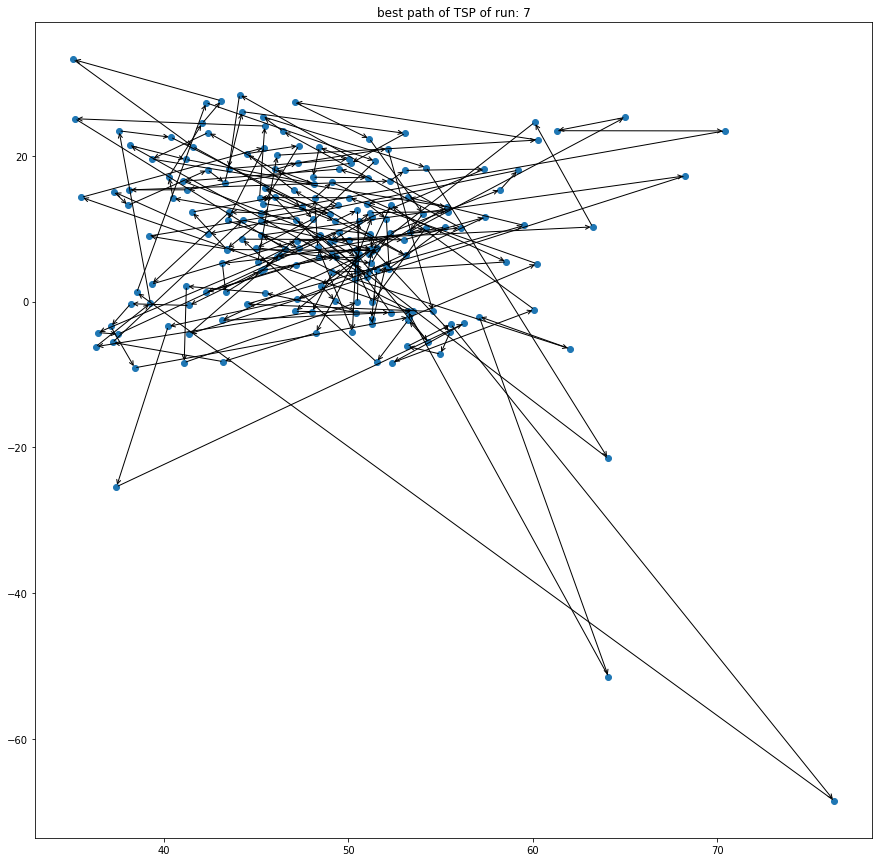

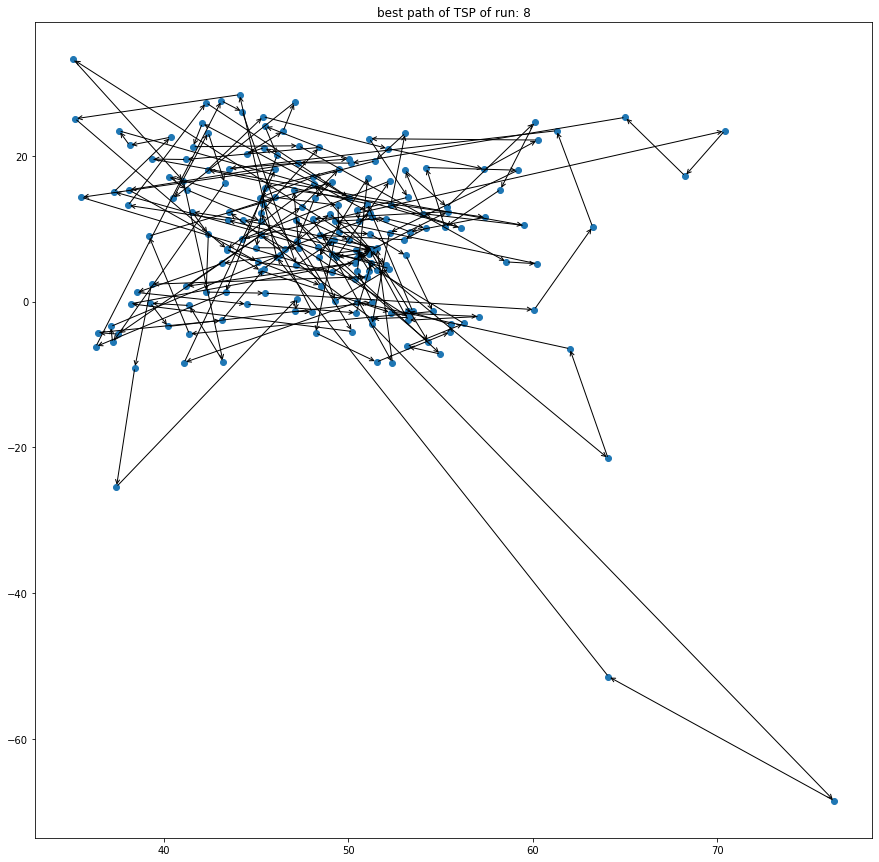

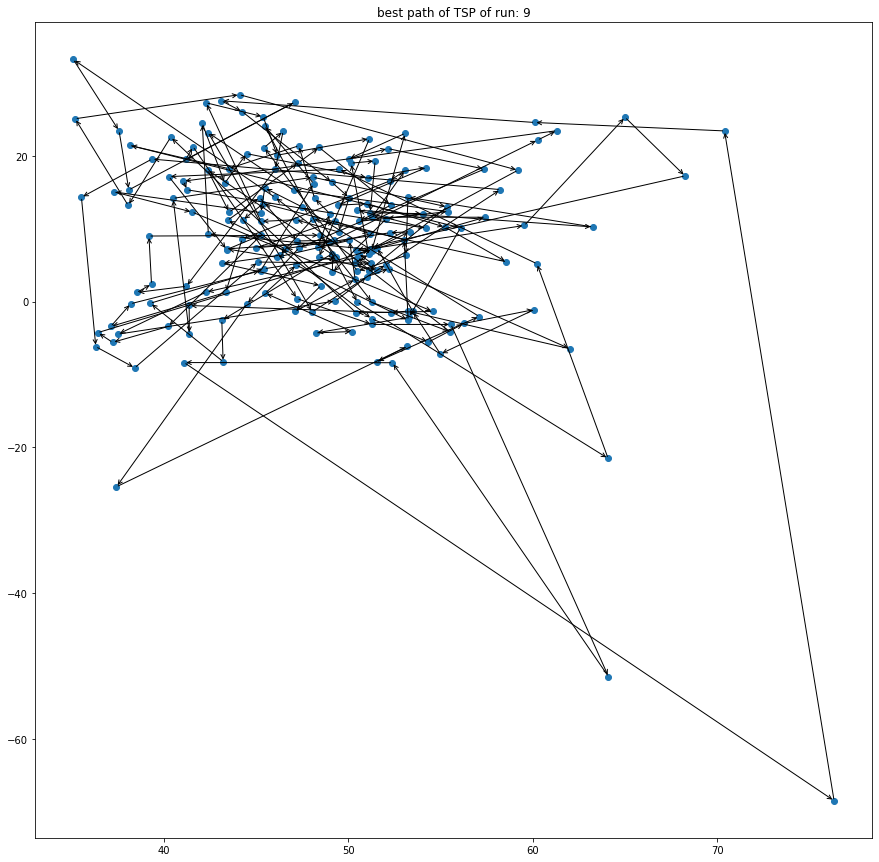

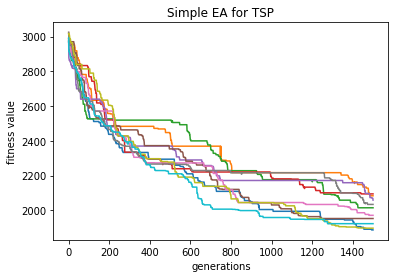

In [536]:
# run simple algorithm with dataset 2
SA2 = simpleEA(places2, number_list2, 0.2, 2, 10 ,1500, 10)
SA2.evolution()

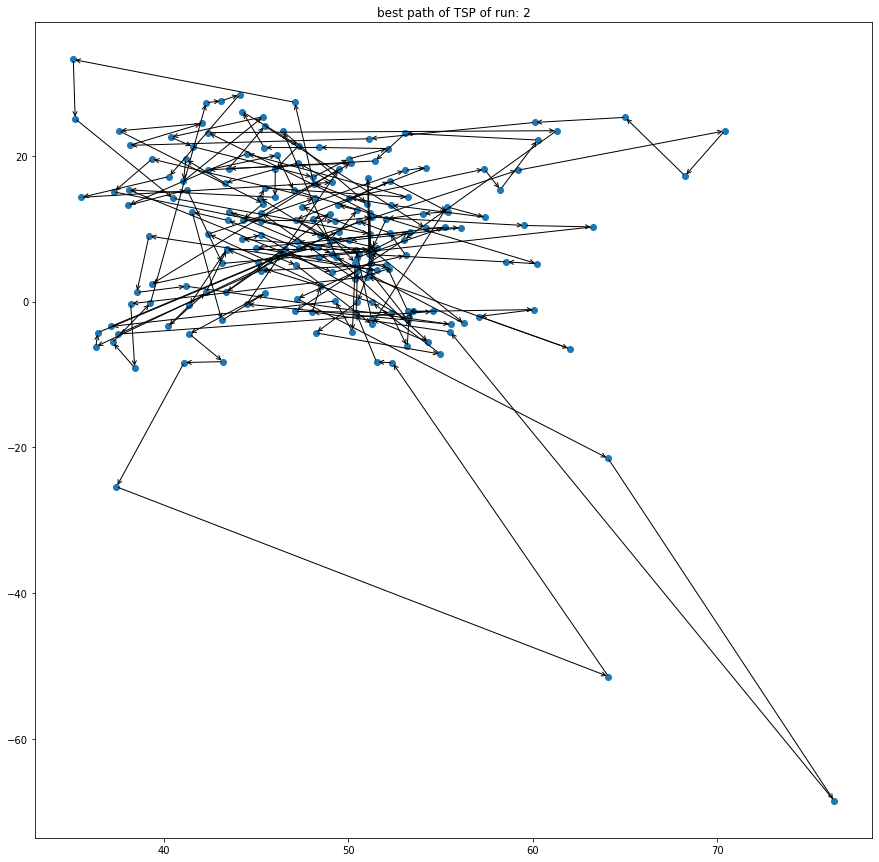

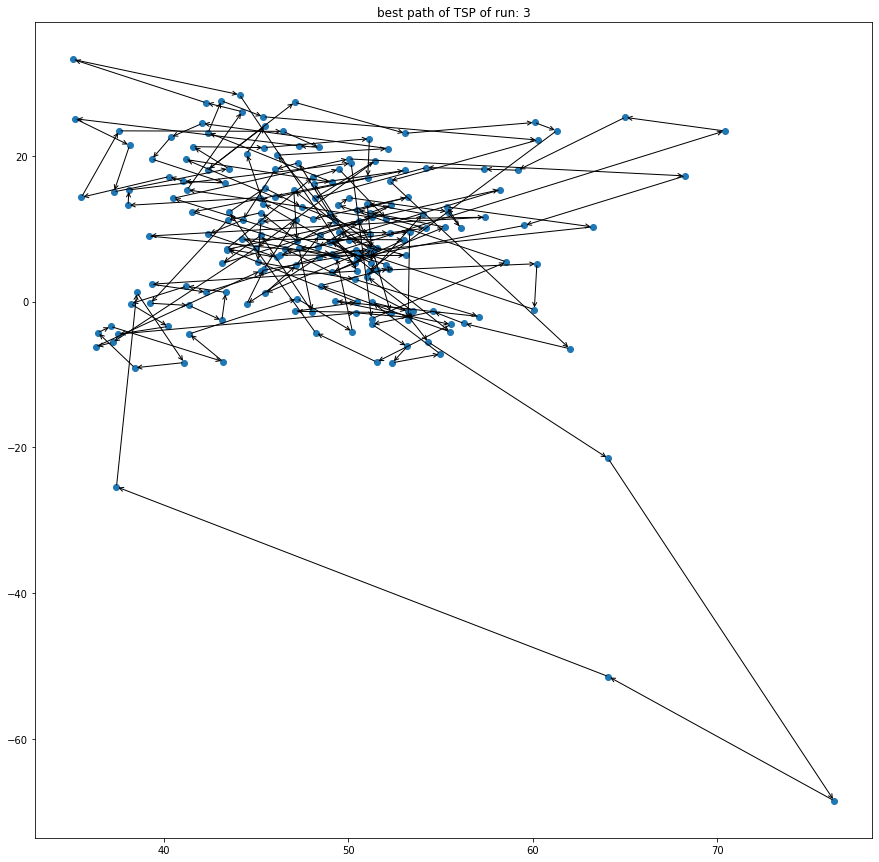

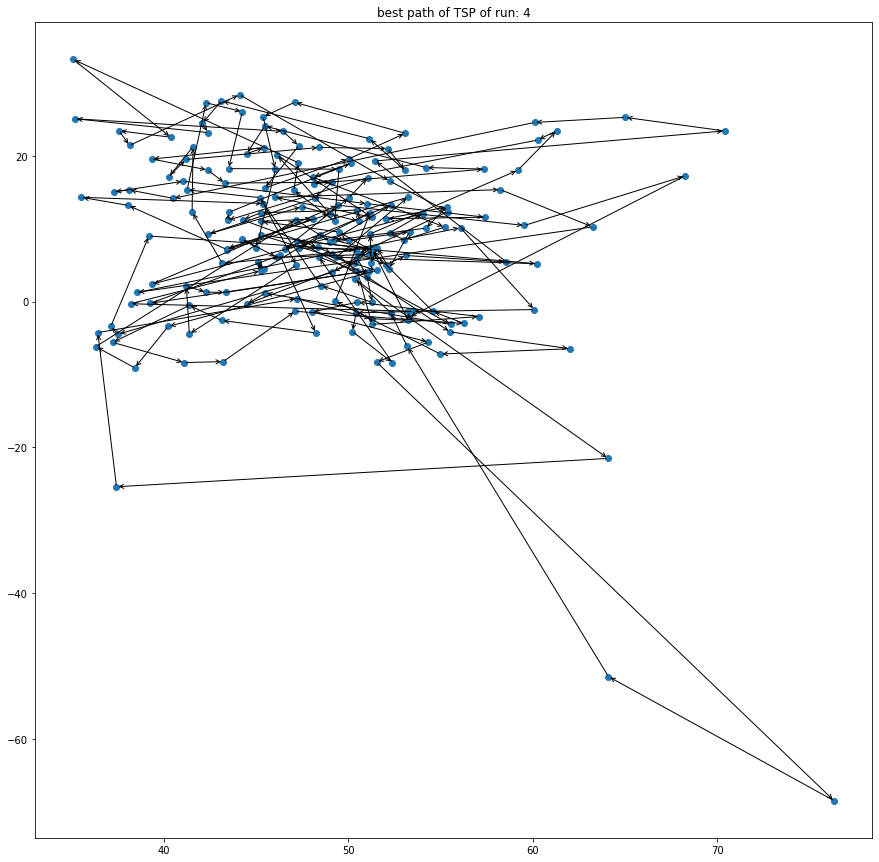

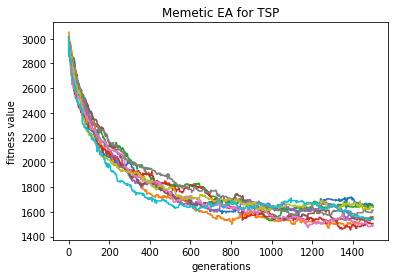

In [581]:
# run memetic algorithm with dataset 2
MA2 = MemeticAlgorithm(places2, number_list2, 0.2, 2, 10 ,1500, 10)
MA2.evolution()

In [539]:
# create alphabet
import string
alphabet = string.ascii_lowercase + ' '
print(alphabet)

abcdefghijklmnopqrstuvwxyz 


In [557]:
class StringGA:
    def __init__(self,target_string, alphabet, mu, k_value, population_size, num_generations, num_runs):
        self.target_string = [*target_string]
        self.alphabet = [*alphabet, ' ']
        self.mu = mu
        self.k_value = k_value
        self.population_size = population_size
        self.num_generations = num_generations
        self.num_runs = num_runs
        self.population = []
        self.new_population = []
        self.t_finish = []
        self.max_fitness = [[] for _ in range(self.num_runs)]
        self.best_string = [[] for _ in range(self.num_runs)]

    def initial_population(self):
        self.population = []
        for _ in range(self.population_size):
            self.population.append(np.random.choice(self.alphabet, size=len(self.target_string)))

    # fitness calculated by calculating how many characters are exactly correct
    def fitness_function(self, string):
        fitness = 0
        for count, letter in enumerate(self.target_string):
            if letter == string[count]:
                fitness += 1

        return fitness
    
    # Tournament selection with K participants 
    def tournament_selection(self):
        self.new_population = []
        self.fitness_values = [self.fitness_function(x) for x in self.population]
        participants = np.random.choice(range(len(self.population)), (self.population_size,self.k_value), replace=True)
        new_fitness = []
        for group in participants:
            fitness_participants = [self.fitness_values[x] for x in group]
            self.new_population.append(self.population[group[np.argmax(fitness_participants)]])
            new_fitness.append(self.fitness_values[group[np.argmax(fitness_participants)]])
        self.population = np.copy(self.new_population)
        self.fitness_values = np.copy(new_fitness)  

    # simple one point crossover with random crossover point
    def crossover(self):
        parents = np.random.choice(range(self.population_size), size=(int(self.population_size/2),2), replace=False)
        for [parent1, parent2] in parents:
            crossover_point = np.random.randint(0,len(self.target_string))
            child1 = np.copy(self.population[parent1])
            child2 = np.copy(self.population[parent2])
            child1[:crossover_point] = self.population[parent2][:crossover_point]
            child2[crossover_point:] = self.population[parent1][crossover_point:]
            self.population[parent1] = np.copy(child1)
            self.population[parent2] = np.copy(child2)
     
    # simple mutation by changing value of random letter
    def mutation(self):
        for count, chromosome in enumerate(self.population):
            if np.random.uniform(0,1) < self.mu:
                numbers = np.random.randint(0,len(self.target_string),size=2)
                self.population[count][numbers[0]] = self.alphabet[numbers[1]] 
            
        # Store data for plots
    def data_storage(self, run):
        best_fitness = np.argmax(self.fitness_values)
        self.max_fitness[run].append(self.fitness_values[best_fitness])
        self.best_string[run].append(self.population[best_fitness])
    
    # plot max fitness values in a graph
    def plot_fitness(self):
        plt.title('Simple EA for string search')
        for run in range(self.num_runs):
            plt.plot(self.max_fitness[run], label=f'max fitness of run: {run}')
        # plt.plot(self.average_fitness, label=f'average fitness of run: {run+1}')
        plt.xlabel('generations')
        plt.ylabel('fitness value')
        plt.show() 

    def plot_string(self, run, gen):
        print(''.join(self.best_string[run][-1])) 
        print(f'number of generations needed to spell {"".join(self.target_string)} is {gen} in run: {run}') 

    def plot_finish_time(self):
        plt.figure(figsize=(10,7))
        sns.distplot(self.t_finish, color="dodgerblue", label="Compact").set(title=f'distribution of t_finish with mean {np.mean(self.t_finish)} and variance: {np.var(self.t_finish)}')

    def evolution(self):
        for run in range(self.num_runs):
            self.initial_population()
            last_gen = self.num_generations
            for gen in range(self.num_generations):
                self.tournament_selection()
                self.crossover()
                self.mutation()
                self.data_storage(run)
                if ''.join(self.best_string[run][-1]) == ''.join(self.target_string):
                    last_gen = gen
                    break
            self.t_finish.append(last_gen)
            self.plot_string(run, last_gen)
        self.plot_fitness()
        self.plot_finish_time()
    

17
natural computing
number of generations needed to spell natural computing is 13 in run: 0
naturan computing
number of generations needed to spell natural computing is 100 in run: 1
natural computing
number of generations needed to spell natural computing is 13 in run: 2
natural computing
number of generations needed to spell natural computing is 11 in run: 3
natural computing
number of generations needed to spell natural computing is 11 in run: 4
natural computing
number of generations needed to spell natural computing is 8 in run: 5
natural camputing
number of generations needed to spell natural computing is 100 in run: 6
natural computing
number of generations needed to spell natural computing is 14 in run: 7
natural computing
number of generations needed to spell natural computing is 15 in run: 8
natural compxting
number of generations needed to spell natural computing is 100 in run: 9
natural computing
number of generations needed to spell natural computing is 14 in run: 10
nafu

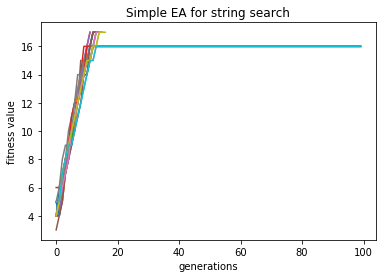

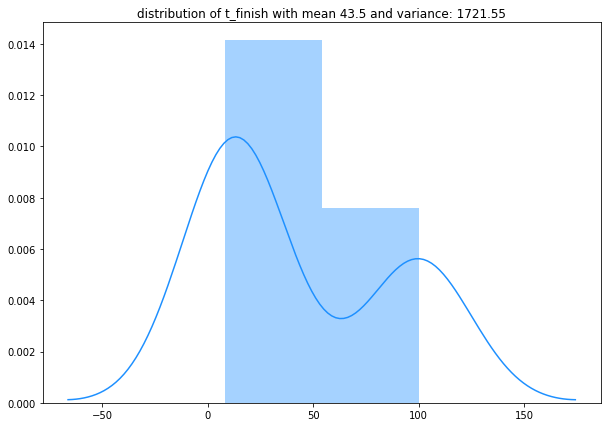

In [558]:
target_string = 'natural computing'
print(len(target_string))


SGA = StringGA(target_string, alphabet, 0.0, 5, 1000, 100, 20) 
SGA.evolution()